In [1]:
# Package imports
from SGD.dynamics import Trainer
from SGD.data import DataGenerator , Perceptron, SkewedCumulant, RademacherCumulant
from SGD.plot_config import *
from SGD.utils import initialize_weights , make_params_dict , save_fig , save_data , load_data 

# Libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# Plot styles
apply_general_styles()

# Simple Example

(10000, 1000)
overlap top eivec and spike:  0.9751524611231155


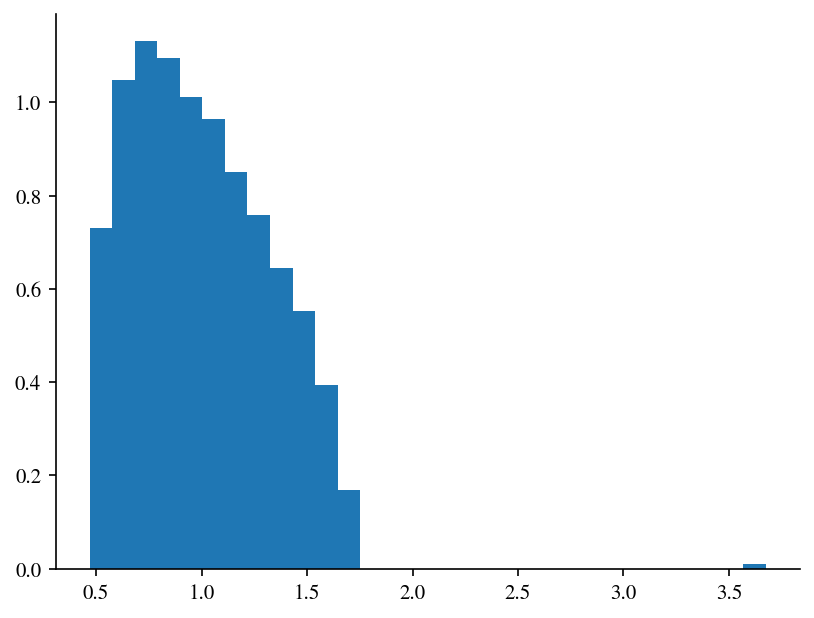

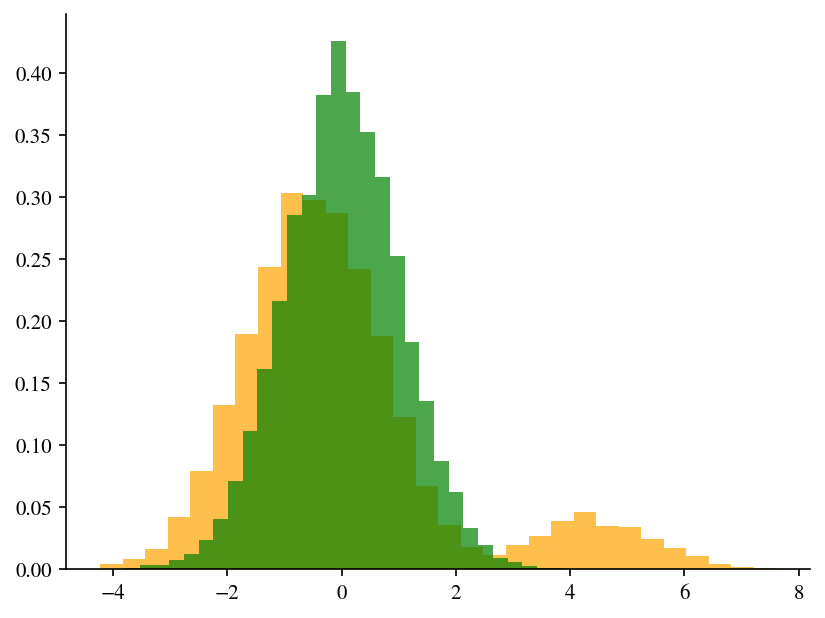

In [27]:
d = 1000
u_spike = np.zeros(d)
u_spike[0] = -1
snr = 5
N = 10000
rng = np.random.default_rng()

# Initialize data model
data_sampler = SkewedCumulant(dim=d,spike=u_spike, snr=snr, rng=rng, p_spike=0.5, rho=0.8,whiten=False)
# data_sampler = RademacherCumulant(dim=d,spike=u_spike, snr=snr, rng=rng,p_spike=1,whiten=True)
# data_sampler = Perceptron(dim=d,w_teacher=u_spike,teacher=teacher,rng=rng)

X = data_sampler.sample(n=N)[0]
print(X.shape)

C = 1/N * X.T @ X
eivals , eivecs = np.linalg.eigh(C)

# sort eigenvalues in descending order
idx = np.argsort(eivals)[::-1]
eivals = eivals[idx]
eivecs = eivecs[:,idx]

# Estimator of u_spike from top eigenvector
u_est = eivecs[:,0]
print("overlap top eivec and spike: ", np.abs(u_est @ u_spike))

plt.hist(eivals, bins=30, density=True)

plt.show()

plt.hist(X[:,0], bins=30, density=True,color='orange',alpha=0.7)
plt.hist(X[:,1], bins=30, density=True,color='green',alpha=0.7)
plt.show()

In [86]:
# Minimal Parameters
d = 200
spike = True
snr = 5.0
teacher = 'He3'
# student = 'He2+He3'
student = 'He3'
loss = 'corr'
k = 3
lr = 0.1 * d**(-0.5*(k)+1)
N_steps = int(40*d**(k-1))
rng = np.random.default_rng()
N_walkers = 10
mode = 'online'  # 'repeat' or 'online'
p_repeat = 1.0
dataset_size = d

# Initialize weights
# np.random.seed()
u_spike, w_initial = initialize_weights(d,m0=1.0/np.sqrt(d),mode='random',N_walkers=N_walkers)

# Initialize data model
# data_sampler = SkewedCumulant(dim=d,spike=u_spike, snr=snr, rng=rng, p_spike=0.5, rho=0.7)
# data_sampler = RademacherCumulant(dim=d,spike=u_spike, snr=snr, rng=rng,p_spike=1)
data_sampler = Perceptron(dim=d,w_teacher=u_spike,teacher=teacher,rng=rng)


In [87]:

# Initialize data generator
data_generator = DataGenerator(data_sampler,N_walkers=N_walkers,mode=mode,dataset_size=dataset_size,p_repeat=p_repeat) 


# Initialize Trainer
trainer = Trainer(d, u_spike, student, loss, lr, data_generator,N_walkers=N_walkers)

# Save data
tprints = np.unique(np.logspace(-0.1,np.log10(N_steps),500).astype(int))
data = {'overlap':[],'times':[]}
# w_initial = w_student.copy()
# Run evolution
t0 = time.time()
print("Starting training...")
for step, (w_student, flag , grad) in enumerate(trainer.evolution(w_initial, N_steps, progress=True)):
    if step in tprints: # Save some steps
        data['overlap'].append(w_student @ u_spike)
        data['times'].append(step)

dt = time.time() - t0
print(f"End training... Took = {dt/60:.4} min")

# Optional Step
for key in data:
    data[key] = np.array(data[key])
    print(key, data[key].shape)

# Save data
name_vars = ['d','snr']
params = make_params_dict(name_vars)
# save_data(data,file_name='test',params=params,base_dir='../data')

# Load data
# data_loaded = load_data(file_name='test',params=params)

Starting training...


100%|██████████| 1600000/1600000 [02:13<00:00, 11948.16it/s]

End training... Took = 2.232 min
overlap (403, 10)
times (403,)


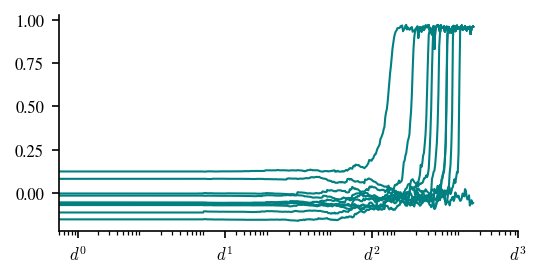

In [88]:
# Other variables
col = pc_colors[0]
xtk = [d**i for i in range(4)]
xlb = [rf'$d^{i}$' for i in range(4)]

# Create figure and plot and font setup
set_font_sizes('normal')
fig , axes = create_fig()
ax = axes
for w in range(N_walkers):
    ax.plot(data['times'],data['overlap'][:,w],color=col,lw=1)
ax.set_xscale('log')
ax.set_xticks(xtk,xlb);

# Save figure
# save_fig(fig, file_name='test', params=params)

scaling exponent:  2.6365092472032097
Prediction for d=2048: T = 2216.12


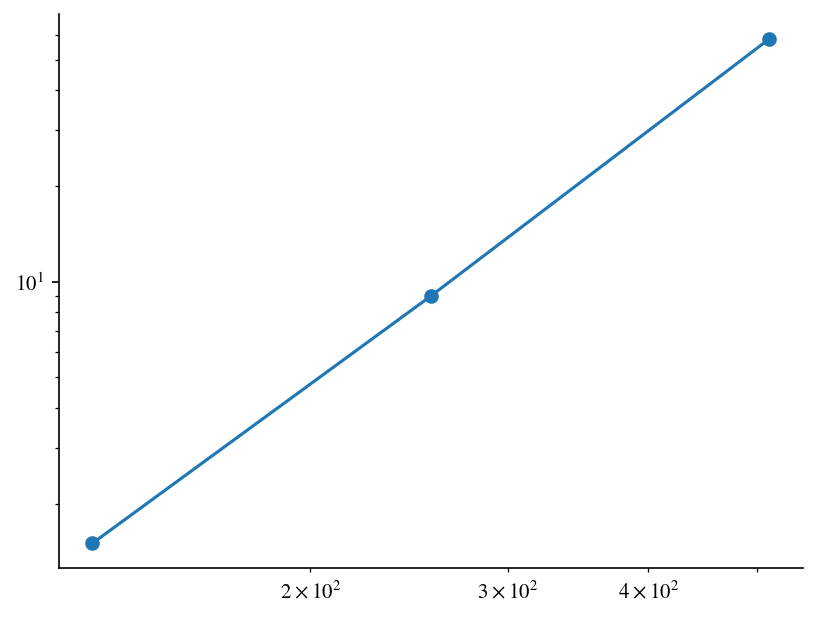

In [8]:
d = [128 ,256 ,512 ]
T = [1.5 , 9, 58]

plt.plot(d,T,'o-')
plt.xscale('log')
plt.yscale('log')
# do the linear regression in log-log scale
log_d = np.log(d)
log_T = np.log(T)
coeffs = np.polyfit(log_d, log_T, 1)
print("scaling exponent: ", coeffs[0])
# The prediction for d_new = 2048 is;
d_new = 2048
log_T_new = coeffs[0] * np.log(d_new) + coeffs[1]
T_new = np.exp(log_T_new)
print(f"Prediction for d={d_new}: T = {T_new:.2f}")
